In [ ]:
%pip install split-folders

In [ ]:
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
#import splitfolders
import PIL.Image as Image

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg16 import VGG16
from keras.applications.mobilenet_v2 import preprocess_input
from keras.applications import imagenet_utils
from keras.preprocessing import image

**Training**
-

In [18]:
BATCH_SIZE = 16
IMG_SHAPE = 224

train_dir = tf.keras.preprocessing.image_dataset_from_directory(batch_size=BATCH_SIZE,
                                                                directory='output/train',
                                                                image_size=(IMG_SHAPE, IMG_SHAPE),
                                                                labels='inferred',
                                                                shuffle = True)

val_dir = tf.keras.preprocessing.image_dataset_from_directory(batch_size=BATCH_SIZE,
                                                              directory='output/val',
                                                              image_size=(IMG_SHAPE, IMG_SHAPE),
                                                              labels='inferred')

test_dir  = tf.keras.preprocessing.image_dataset_from_directory(batch_size=BATCH_SIZE,
                                                              directory='output/test',
                                                              image_size=(IMG_SHAPE, IMG_SHAPE),
                                                              labels='inferred')

Found 359 files belonging to 2 classes.
Found 74 files belonging to 2 classes.
Found 78 files belonging to 2 classes.


In [22]:
data_augmentation = Sequential([
     layers.RandomFlip("horizontal", input_shape=(IMG_SHAPE, IMG_SHAPE, 3)),
     layers.RandomRotation(0.2)
])

In [23]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [24]:
#helps with efficiency since it caches and 
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_dir.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_dir.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_dir.cache().prefetch(buffer_size=AUTOTUNE)

In [25]:
#num_classes = 2
base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_SHAPE,IMG_SHAPE,3),
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

In [ ]:
base_model.summary()

In [17]:
keras.backend.clear_session()

In [26]:
#functional api
inputs = tf.keras.Input(shape = (IMG_SHAPE, IMG_SHAPE, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
predictLayer = Dense(1, activation= 'sigmoid')(x)
model = tf.keras.Model(inputs, predictLayer)

In [27]:
base_learning_rate = 0.0001
initial_epochs = 25
early_stop_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate)

model.compile(optimizer=optimizer,
              loss="binary_crossentropy",
              metrics=['accuracy'])

history = model.fit(train_ds, epochs=initial_epochs, validation_data=val_ds,
             callbacks=[early_stop_cb])

Epoch 1/25
23/23 [==============================] - 28s 961ms/step - loss: 0.8554 - accuracy: 0.5153 - val_loss: 0.6269 - val_accuracy: 0.6216
Epoch 2/25
23/23 [==============================] - 21s 890ms/step - loss: 0.6724 - accuracy: 0.6490 - val_loss: 0.5309 - val_accuracy: 0.7027
Epoch 3/25
23/23 [==============================] - 20s 892ms/step - loss: 0.6095 - accuracy: 0.6741 - val_loss: 0.4917 - val_accuracy: 0.7297
Epoch 4/25
23/23 [==============================] - 20s 881ms/step - loss: 0.5760 - accuracy: 0.7075 - val_loss: 0.4536 - val_accuracy: 0.7703
Epoch 5/25
23/23 [==============================] - 20s 897ms/step - loss: 0.5103 - accuracy: 0.7549 - val_loss: 0.4293 - val_accuracy: 0.7838
Epoch 6/25
23/23 [==============================] - 20s 866ms/step - loss: 0.4692 - accuracy: 0.7437 - val_loss: 0.3996 - val_accuracy: 0.8108
Epoch 7/25
23/23 [==============================] - 19s 826ms/step - loss: 0.4478 - accuracy: 0.7883 - val_loss: 0.3704 - val_accuracy: 0.8378

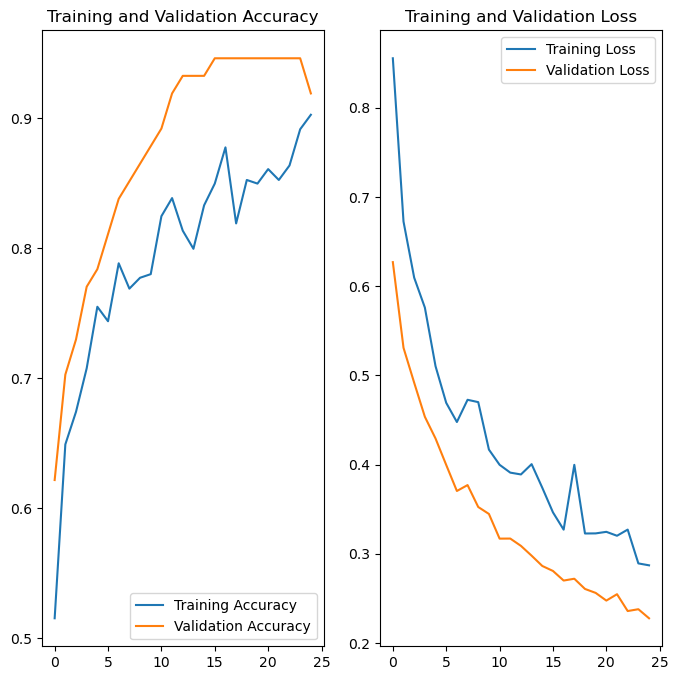

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(25)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [54]:
test_loss, test_accuracy = model.evaluate(test_dir, batch_size=32)

print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

5/5 [==============================] - 3s 600ms/step - loss: 0.3131 - accuracy: 0.9103
Test Loss:     0.3130946159362793
Test Accuracy: 0.9102563858032227


In [ ]:
# Save Model
model.save("Binary_CNN_Model")

In [ ]:
#download model
model.save("model.h5". save_format = 'h5')
!tar -zcvf model.tar.gz model.h5
model_key = 'models/mobilenet-keras/model.tar.gz'
boto3.resource('s3').Bucket(BUCKET).upload_file('model.tar.gz', model_key)